# Load Dataset

In [1]:
import pandas as pd

# CSV file load karo
df = pd.read_csv("TrafficTwoMonth.csv")

# Pehle 5 rows dekho
print(df.head())


          Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        13          2         2   
1  12:15:00 AM    10         Tuesday        14          1         1   
2  12:30:00 AM    10         Tuesday        10          2         2   
3  12:45:00 AM    10         Tuesday        10          2         2   
4   1:00:00 AM    10         Tuesday        11          2         1   

   TruckCount  Total Traffic Situation  
0          24     41            normal  
1          36     52            normal  
2          32     46            normal  
3          36     50            normal  
4          34     48            normal  


# Check Missing Values & Data Types

In [2]:
print(df.info())   # Data types check karne ke liye
print(df.isnull().sum())  # Missing values dekho


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               5952 non-null   object
 1   Date               5952 non-null   int64 
 2   Day of the week    5952 non-null   object
 3   CarCount           5952 non-null   int64 
 4   BikeCount          5952 non-null   int64 
 5   BusCount           5952 non-null   int64 
 6   TruckCount         5952 non-null   int64 
 7   Total              5952 non-null   int64 
 8   Traffic Situation  5952 non-null   object
dtypes: int64(6), object(3)
memory usage: 418.6+ KB
None
Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64


# Convert Time & Day to Numerical Format

In [3]:


# 🕒 Convert Time to 24-hour format (extract Hour)
df["Hour"] = pd.to_datetime(df["Time"], format="%I:%M:%S %p").dt.hour

# 🗓️ Convert Day of the Week to Numerical (Monday=0, ..., Sunday=6)
days_mapping = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
                "Friday": 4, "Saturday": 5, "Sunday": 6}
df["Weekday"] = df["Day of the week"].map(days_mapping)

# 🔥 Drop Unnecessary Columns
df.drop(columns=["Time", "Day of the week"], inplace=True)

# 🔍 Check Data After Transformation
print(df.head())


   Date  CarCount  BikeCount  BusCount  TruckCount  Total Traffic Situation  \
0    10        13          2         2          24     41            normal   
1    10        14          1         1          36     52            normal   
2    10        10          2         2          32     46            normal   
3    10        10          2         2          36     50            normal   
4    10        11          2         1          34     48            normal   

   Hour  Weekday  
0     0        1  
1     0        1  
2     0        1  
3     0        1  
4     1        1  


# Encode Traffic Situation (Target Variable)

In [4]:
from sklearn.preprocessing import LabelEncoder

# 🎯 Encode Traffic Situation (Categorical → Numerical)
label_enc = LabelEncoder()
df["Traffic Situation"] = label_enc.fit_transform(df["Traffic Situation"])

# 🏷️ Check Encoding Mapping
print(label_enc.classes_)  # ['Heavy' 'High' 'Low' 'Normal']


['heavy' 'high' 'low' 'normal']


# Define Features (X) & Target (y)

In [5]:
# 🎯 Define Features (X) and Target (y)
X = df[["Hour", "Weekday", "CarCount", "BikeCount", "BusCount", "TruckCount", "Total"]]
y = df["Traffic Situation"]


# Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

# 📌 80-20 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Check Data Shapes
print(X_train.shape, X_test.shape)


(4761, 7) (1191, 7)


# Train a Random Forest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier

# 🌲 Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# Evaluate Model Performance

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 🔍 Predict on Test Data
y_pred = model.predict(X_test)

# 🎯 Accuracy Check
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
# 📊 Classification Report
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.9966414777497901

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       228
           1       1.00      0.97      0.99        74
           2       1.00      1.00      1.00       167
           3       1.00      1.00      1.00       722

    accuracy                           1.00      1191
   macro avg       1.00      0.99      0.99      1191
weighted avg       1.00      1.00      1.00      1191



# Confusion Matrix

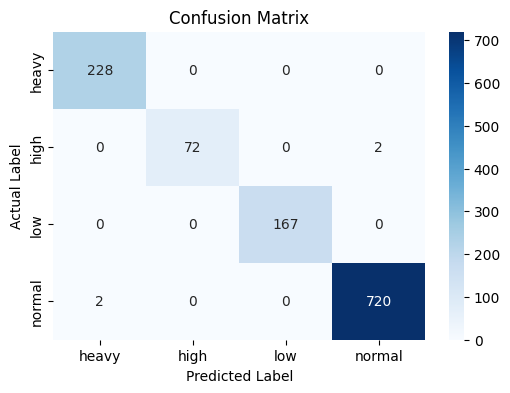

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve and AUC Score

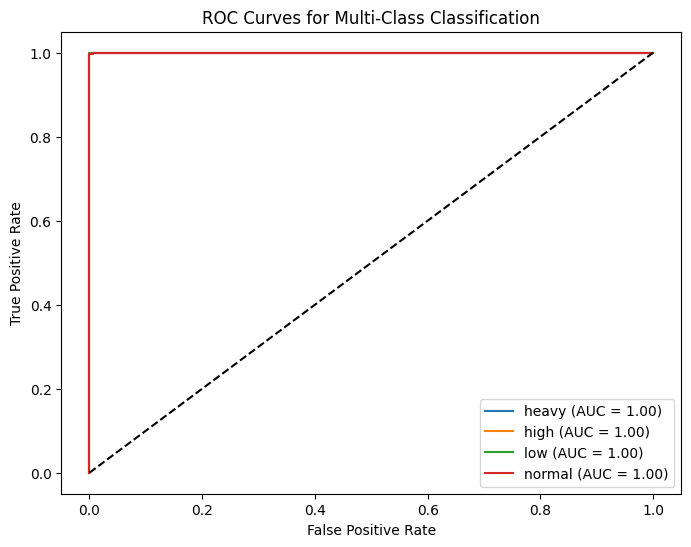

In [10]:
y_prob = model.predict_proba(X_test)  # Get probability scores

# Multiclass ROC Curve
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(label_enc.classes_):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend()
plt.show()

# Cross-Validation Score

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"✅ Cross-Validation Accuracy Scores: {cv_scores}")
print(f"✅ Mean CV Accuracy: {cv_scores.mean():.4f}")

✅ Cross-Validation Accuracy Scores: [0.99580273 0.99789916 0.99579832 0.99579832 0.99789916]
✅ Mean CV Accuracy: 0.9966


# Test Model on New Data

In [12]:
# 🚦 Sample Input: 9 AM, Wednesday, 50 Cars, 10 Bikes, 5 Buses, 2 Trucks, 67 Total
sample_input = [[9, 2, 50, 10, 5, 2, 67]]

# 🔮 Predict Traffic Situation
predicted_traffic = model.predict(sample_input)

# 🏷️ Convert Numerical Output to Label
print("Predicted Traffic Situation:", label_enc.inverse_transform(predicted_traffic))


Predicted Traffic Situation: ['low']


C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# Save the model to a file using pickle


In [13]:
import pickle
with open('traffic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model trained and saved as 'traffic_model.pkl'")


Model trained and saved as 'traffic_model.pkl'


In [14]:
# ✅ Encode 'Traffic Situation'
label_enc = LabelEncoder()
df['Traffic Situation'] = label_enc.fit_transform(df['Traffic Situation'])

# ✅ Save Label Encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_enc, f)

print("✅ Label encoder saved as 'label_encoder.pkl'")

✅ Label encoder saved as 'label_encoder.pkl'


In [15]:
print("Model and label encoder saved successfully.")
print(f"Model accuracy on test set: {model.score(X_test, y_test):.4f}")
print(f"Label encoder classes: {label_enc.classes_}")

Model and label encoder saved successfully.
Model accuracy on test set: 0.9966
Label encoder classes: [0 1 2 3]
